# Importing Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import differential_entropy,kurtosis
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm
from tqdm import tqdm

# Majewski Model Simulation

The `Majew` function simulates financial time series data based on the Majewski et al. model. This model incorporates :
- `gamma`: Controls the sensitivity to the trend.
- `alpha`: Smoothing parameter for the trend.
- `kappa1`: Strength of the mean-reversion to the fundamental value.
- `beta`: Strength of the nonlinear response to the trend.
- `Lambda`: Smoothing parameter for the fundamental value.
- `sigmav`: Standard deviation of the noise term added to the price.

The function returns the simulated price (`p`) and return (`r`) time series.


In [3]:
def Majew(gamma, alpha, kappa1, beta, Lambda, sigmav, length=1000, nb=1):
    """
    Simulate the Majewski et al. model for financial time series.

    Parameters:
    gamma (float): Parameter gamma in the model.
    alpha (float): Parameter alpha in the model.
    kappa1 (float): Parameter kappa1 in the model.
    beta (float): Parameter beta in the model.
    Lambda (float): Parameter Lambda in the model.
    sigmav (float): Standard deviation of the noise term.
    length (int): Length of the time series to simulate. Default is 1000.
    nb (int): Number of simulations to run. Default is 1.

    Returns:
    tuple: Simulated price (p) and return (r) time series.
    """


    # Generate random noise for the simulations
    Epsilon = np.random.normal(0, sigmav**2, (length, nb))
    v = np.zeros((length, nb))
    m = np.zeros((length, nb))

    # Initialize price and return arrays
    p = np.zeros((length, nb))
    r = np.zeros((length, nb))

    # Simulation loop
    for t in range(1, length - 1):
        # Update the fundamental value
        v[t] = (1 - Lambda) * v[t - 1] + Lambda * p[t]
        
        # Update the moving average of the trend
        m[t] = (1 - alpha) * m[t - 1] + alpha * (p[t] - p[t - 1])
        
        # Update the price
        p[t + 1] = p[t] + kappa1 * (v[t] - p[t]) + beta * np.tanh(gamma * m[t]) + Epsilon[t + 1]
        
        # Calculate the return
        r[t + 1] = p[t + 1] - p[t]
    
    return p, r


# Enhanced Majewski Model Simulation

In this version of the Majewski et al. model, we have added a cubic term with kappa3.


In [4]:
def Majew2(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, length=1000, nb=1):
    """
    Simulate the enhanced Majewski et al. model for financial time series with an additional nonlinear term.

    Parameters:
    gamma (float): Parameter gamma in the model.
    alpha (float): Parameter alpha in the model.
    kappa1 (float): Parameter kappa1 in the model.
    kappa3 (float): Parameter for the cubic term in the model.
    beta (float): Parameter beta in the model.
    Lambda (float): Parameter Lambda in the model.
    sigmav (float): Standard deviation of the noise term.
    length (int): Length of the time series to simulate. Default is 1000.
    nb (int): Number of simulations to run. Default is 1.

    Returns:
    tuple: Simulated price (p) and return (r) time series.
    """
    # Generate random noise for the simulations
    Epsilon = np.random.normal(0, sigmav**2, (length, nb))
    v = np.zeros((length, nb))
    m = np.zeros((length, nb))

    # Initialize price and return arrays
    p = np.zeros((length, nb))
    r = np.zeros((length, nb))

    # Simulation loop
    for t in range(1, length - 1):
        # Update the fundamental value
        v[t] = (1 - Lambda) * v[t - 1] + Lambda * p[t]
        
        # Update the moving average of the trend
        m[t] = (1 - alpha) * m[t - 1] + alpha * (p[t] - p[t - 1])
        
        # Update the price with an additional cubic term
        p[t + 1] = p[t] + kappa1 * (v[t] - p[t]) + kappa3 * (v[t] - p[t])**3 + beta * np.tanh(gamma * m[t]) + Epsilon[t + 1]
        
        # Calculate the return
        r[t + 1] = p[t + 1] - p[t]
    
    return p, r


### Majewski Simulation Example


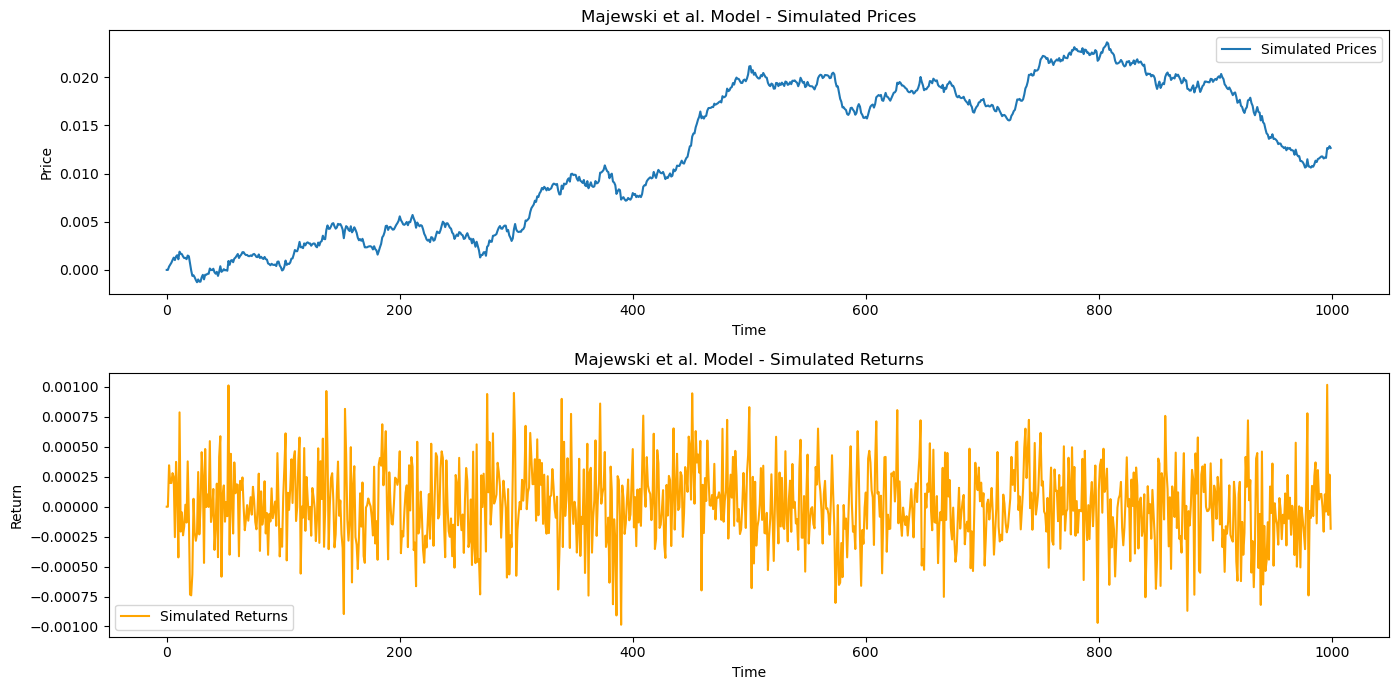

In [9]:
# Parameters for the Majewski model
gamma = 36.7
alpha = 1.0/7
kappa1 = 0.015
beta = 0.015
Lambda = 0.05
sigmav = 0.018
length = 1000
nb = 1

# Run the simulation
prices, returns = Majew(gamma, alpha, kappa1, beta, Lambda, sigmav, length, nb)

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(prices, label='Simulated Prices')
plt.title('Majewski et al. Model - Simulated Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(returns, label='Simulated Returns', color='orange')
plt.title('Majewski et al. Model - Simulated Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()

plt.tight_layout()
plt.show()


### Enhanced Majewski Model Simulation Example


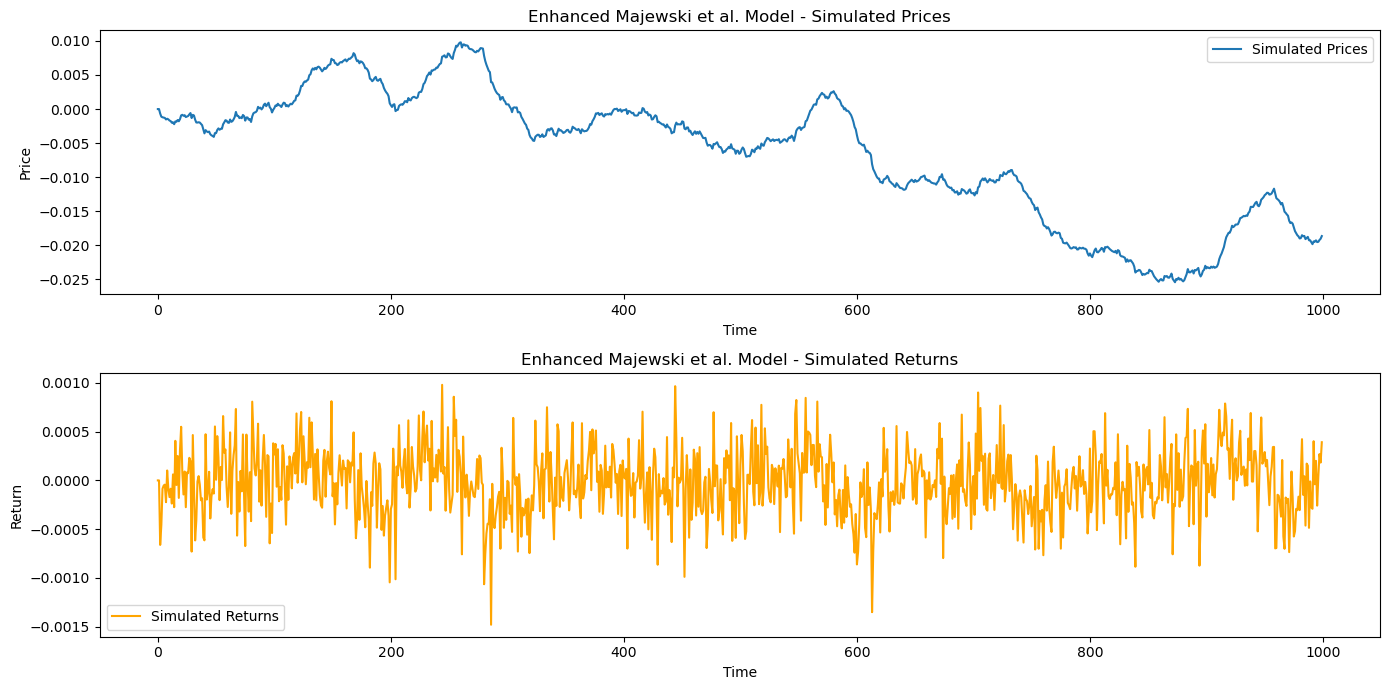

In [8]:
# Parameters for the enhanced Majewski model
gamma = 36.7
alpha = 1.0/7
kappa1 = -0.011000
kappa3 = 0.269000
beta = 0.018
Lambda = 0.1
sigmav = 0.018
length = 1000
nb = 1

# Run the enhanced simulation
prices2, returns2 = Majew2(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, length, nb)

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(prices2, label='Simulated Prices')
plt.title('Enhanced Majewski et al. Model - Simulated Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(returns2, label='Simulated Returns', color='orange')
plt.title('Enhanced Majewski et al. Model - Simulated Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()

plt.tight_layout()
plt.show()


# Compute Statistics of Returns

The `compute_statistics` function calculates various statistics for a given series of financial returns:
- Mean
- Standard deviation
- Kurtosis
- Ratio of the 10th to 95th percentile of the absolute returns
- Autocorrelation of returns
- Autocorrelation of squared returns

If the `cov` parameter is set to `True`, the function also returns the covariance matrix of these statistics simulations.


In [10]:
def compute_statistics(r, cov=False):
    """
    Compute various statistics for the given return series.

    Parameters:
    r (array-like): Array of return series.
    cov (bool): Whether to return the covariance matrix of the statistics. Default is False.

    Returns:
    tuple: Array of computed statistics. If cov is True, also returns the covariance matrix.
    """
    # Calculate the mean of the returns
    means = np.nanmean(r, axis=0)
    
    # Calculate the standard deviation of the returns
    std_dev = np.nanstd(r, axis=0)
    
    # Calculate the kurtosis of the returns
    kurtosiss = kurtosis(r, axis=0)
    
    # Calculate the 10th and 95th percentiles of the absolute returns
    abs_r = np.abs(r)
    q1 = np.nanpercentile(abs_r, 10, axis=0)
    q2 = np.nanpercentile(abs_r, 95, axis=0)
    rat_quantile = q1 / q2
    
    if r.shape[1] == 1:
        # Calculate the autocorrelation of returns and squared returns for single time series
        aut_r = sm.tsa.acf(r, nlags=1)[1]
        aut_rc = sm.tsa.acf(r**2, nlags=1)[1]
    else:
        # Calculate the autocorrelation of returns and squared returns for multiple time series
        deltar = (r - np.nanmean(r, axis=0)) / np.nanstd(r, axis=0)
        aut_r = np.array([sm.tsa.acf(deltar[:, i], nlags=3)[1] for i in range(r.shape[1])])
        aut_rc = np.array([sm.tsa.acf((deltar[:, i])**2, nlags=3)[1] for i in range(r.shape[1])])

    if cov:
        # Stack all simulations of the statistics for covariance calculation
        mf = np.vstack([means, std_dev, kurtosiss, rat_quantile, aut_r, aut_rc])
        W = np.cov(mf)
        return np.array([np.nanmean(means), np.nanmean(std_dev), np.nanmean(kurtosiss), np.nanmean(rat_quantile), np.nanmean(aut_r), np.nanmean(aut_rc)]), W
    
    return np.array([np.nanmean(means), np.nanmean(std_dev), np.nanmean(kurtosiss), np.nanmean(rat_quantile), np.nanmean(aut_r), np.nanmean(aut_rc)])


### Example: Compute and Plot Statistics


In [16]:
# Parameters for the Majewski  model
gamma = 0.1
alpha = 0.3
kappa1 = 0.2
beta = 0.5
Lambda = 0.4
sigmav = 0.1
length = 1000
nb = 1

# Run the simulation
prices, returns = Majew(gamma, alpha, kappa1, beta, Lambda, sigmav, length, nb)

# Compute statistics
stats = compute_statistics(returns, cov=False)

# Display the computed statistics
print("Mean:", stats[0])
print("Standard Deviation:", stats[1])
print("Kurtosis:", stats[2])
print("Ratio of 10th to 95th Percentile:", stats[3])
print("Autocorrelation of Returns:", stats[4])
print("Autocorrelation of Squared Returns:", stats[5])



Mean: -0.00018057587203194664
Standard Deviation: 0.010059366419768408
Kurtosis: -0.1809321417478289
Ratio of 10th to 95th Percentile: 0.06663799883413539
Autocorrelation of Returns: -0.11875721388820022
Autocorrelation of Squared Returns: -0.01635886551572467


# Cost Function and Optimization


The `cost` function calculates the cost for a given set of parameters $\xi$. It uses the `Majew` function to simulate returns, computes statistics on these returns, and compares them to target statistics $\hat{c}_k$ using a weight matrix $W$.

Given a quantity of interest $c_k$, we measure it in real data $\hat{c}_{k,\mathcal{R}}$ and in the ABM model $\hat{c}_{k,\text{ABM}}(\xi)$. We define the distance as:

$$D_W(\xi) = \sum_{i,k=1}^{K} (\hat{c}_{i,\text{ABM}} - \hat{c}_{i,\mathcal{R}}) W_{ik} (\hat{c}_{k,\text{ABM}} - \hat{c}_{k,\mathcal{R}})$$

The goal is to find $\xi$ that minimizes $D_W$.

To achieve accurate results, we perform many simulations to estimate the covariance matrix $W$. Due to the stochastic nature of the simulations, we compute the average statistics, which best describe the returns using the `compute_statistics` function. This ensures a robust estimation of parameters.


In [17]:
def cost(ksi, W, c_thilde, Majewi=Majew):
    """
    Calculate the cost function for the given parameters.

    Parameters:
    ksi (array-like): Parameters for the Majewski et al. model.
    W (array-like): Weight matrix (principally cov matrix) for the cost function.
    c_thilde (array-like): Target statistics.
    Majewi (function): Function to simulate the Majewski model. Default is Majew.

    Returns:
    float: Value of the cost function.
    """
    _, r = Majewi(*ksi, nb=100)
    cabm, V = compute_statistics(r, cov=True)
    dc = c_thilde - cabm
    D = dc.T @ W @ dc
    return D


# Find Optimal Parameters Function

The `find_optimalksi` function aims to find the optimal parameters $\xi$ for the Majewski model using the Generalized Method of Moments (GMM). This optimization process iteratively updates the parameter estimates and the weight matrix $W$ based on the covariance matrix of the moment conditions. The process follows the recommended iterative procedure as illustrated:

1. Start with an initial weight matrix $W^{(0)}$.
2. Find the optimal parameters $\xi^{(0)}$ by minimizing the cost function.
3. Update the weight matrix $W^{(1)}$ using simulations with $\xi^{(0)}$:
   - Simulate the model many times with $\xi = \xi^{(0)}$.
   - Compute the covariance of the moment conditions between the runs.
4. Repeat steps 2 and 3 until $\left| \xi^{(n)} - \xi^{(n-1)} \right| < \epsilon$.

The goal is to find $\xi$ that minimizes $D_W$.

This function requires extensive simulations to estimate the covariance matrix $W$. Due to the stochastic nature of the simulations, it averages the statistics that best define the returns using the `compute_statistics` function. This ensures a robust estimation of parameters.


The error is calculated to determine the convergence of the optimization process. The error is defined as the L1 norm of the relative change in parameters between successive iterations.

Mathematically, it is represented as:

$$
\text{error} = \left\| \left| \frac{\xi^{(n+1)}}{\xi^{(n)}} \right| - \mathbf{1} \right\|_1
$$

where:
- $\xi^{(n)}$ and $\xi^{(n+1)}$ are the parameter vectors at the $n$-th and $(n+1)$-th iterations respectively.
- $\mathbf{1}$ is a vector of ones.

This calculation measures the relative change in each parameter, scaled to avoid issues with parameters of different magnitudes. The L1 norm (sum of absolute values) is used to aggregate the changes into a single error metric. The optimization process continues until this error falls below a specified threshold $\epsilon$, indicating that the parameters have converged.




In [20]:
def find_optimalksi(params=[36.7, 1/7, 0.015, 0.015, 0.05, 0.018], cost=cost,\
     Majewi=Majew, epsilon=0.1, maxiter=100, print_res=True, dis=True, c_thilde=[]):
     
    """
    Find the optimal parameters for the Majewski et using the given cost function.

    Parameters:
    params (list): Initial parameters for the Majewski model.
    cost (function): Cost function to minimize. Default is cost.
    Majewi (function): Function to simulate the Majewski  model. Default is Majew.
    epsilon (float): Convergence threshold. Default is 0.1.
    maxiter (int): Maximum number of iterations. Default is 100.
    print_res (bool): Whether to print intermediate results. Default is True.
    dis (bool): Whether to display optimization output. Default is True.
    c_thilde (list): Target statistics. Default is an empty list.

    Returns:
    tuple: Target statistics and optimized parameters.
    """
    # If target statistics are not provided, simulate initial parameters to get target statistics
    if len(c_thilde) == 0:
        _, r_thild = Majewi(*params)
        c_thilde = compute_statistics(r_thild)
    
    # Define bounds for the optimization based on a percentage range around initial parameters
    percentage_range = 0.3  # 30% range
    bounds = [(min(param * (1 - percentage_range), param * (1 + percentage_range)), 
               max(param * (1 - percentage_range), param * (1 + percentage_range))) for param in params]
    
    # Options for the optimization algorithm
    options = {'maxiter': 1000, 'disp': dis}
    
    # Initialize parameters randomly within the bounds
    ksi = [np.random.uniform(low, high) for low, high in bounds]
    
    # Simulate returns with the initial parameters
    _, r = Majewi(*ksi, nb=100)
    # Compute statistics and covariance matrix
    cabm, V = compute_statistics(r, cov=True)
    # Compute the inverse of the covariance matrix to get the weight matrix
    W = np.linalg.inv(V)
    
    i = 1
    while True:
        # Minimize the cost function
        res = minimize(cost, ksi, args=(W, c_thilde, Majewi), method='Powell', bounds=bounds, options=options)
        # Calculate the error as the norm of the relative change in parameters
        error = np.linalg.norm(np.abs(res.x / ksi) - np.ones(len(params)), ord=1)
        
        if print_res:
            print(f"Step {i} result: ", error)
            print(f"n : {ksi}\nn+1 : {res.x}")
        
        # Update parameters
        ksi = res.x
        if (error < epsilon) or (i >= maxiter):
            break
        
        # Simulate returns with updated parameters
        _, r = Majewi(*ksi, nb=100)
        # Compute statistics and update the weight matrix
        cabm, V = compute_statistics(r, cov=True)
        W = np.linalg.inv(V)
        i += 1

    return c_thilde, ksi



# Densities Calculation Function

The `densities` function repeats the optimization process multiple times to obtain the distribution of optimal parameters $\xi$. This is to analyse the variability and robustness of the parameter estimates.

1. **Initial Simulation**:
   - Simulate returns with the initial parameters to compute the target statistics $\hat{c}_{\tilde{c}}$.

2. **Optimization Loop**:
   - Perform the optimization `nb_simulations` times.
   - In each iteration, the function `find_optimalksi` is called to find the optimal parameters $\xi$.
   - Append the optimal parameters from each iteration to the list `ksi`.

3. **Output**:
   - The function returns a list of optimal parameter sets obtained from each simulation, allowing for the analysis of their distribution.

This repeated optimization process provides insight into the stability and reliability of the estimated parameters under different initial conditions and stochastic variations.


In [22]:
def densities(nb_simulations=100, params=[36.7, 1/7, 0.015, 0.015, 0.05, 0.018], cost=cost, Majewi=Majew, epsilon=0.3, maxiter=100, print_res=True):
    """
    Repeat the optimization process multiple times to obtain the distribution of optimal parameters.

    Parameters:
    nb_simulations (int): Number of simulations to perform. Default is 100.
    params (list): Initial parameters for the Majewski model.
    cost (function): Cost function to minimize. Default is cost.
    Majewi (function): Function to simulate the Majewski model. Default is Majew.
    epsilon (float): Convergence threshold. Default is 0.3.
    maxiter (int): Maximum number of iterations. Default is 100.
    print_res (bool): Whether to print intermediate results. Default is True.

    Returns:
    list: List of optimal parameter sets obtained from each simulation.
    """
    # Simulate returns with initial parameters to get target statistics
    _, r_thild = Majewi(*params)
    c_thilde = compute_statistics(r_thild)

    ksi = []
    for i in tqdm(range(nb_simulations)):
        # Perform the optimization to find optimal parameters
        optimal_ksi = find_optimalksi(params=params, cost=cost, Majewi=Majewi, epsilon=epsilon, maxiter=maxiter, print_res=False, dis=False, c_thilde=c_thilde)[1]
        ksi.append(optimal_ksi)
        if print_res:
            print(optimal_ksi)

    return ksi


In [7]:
options = {
    'maxiter': 1000, 
    'disp': True,
    'adaptive': False
}
init = (30.7,1/5,0.095,0.005,0.2,0.09)
bounds = [(36.7*0.3,36.7*1.7),((1/7)*0.3,(1/7)*1.7),(0.015*0.3,0.015*1.7),(0.015*0.3,0.015*1.7),(0.1*0.3,0.1*1.7),(0.018*0.3,0.018*1.7)]
res = minimize(cost, init, method='Powell', options=options, bounds=bounds)


/tmp/ipykernel_1303/922999621.py:8: OptimizeWarning: Unknown solver options: adaptive
  res = minimize(cost, init, method='Powell', options=options, bounds=bounds)
/tmp/ipykernel_1303/922999621.py:8: OptimizeWarning: Initial guess is not within the specified bounds
  res = minimize(cost, init, method='Powell', options=options, bounds=bounds)


2653.1596987722332
1864.864494535278
1754.3535326909202
1954.0244050280533
2222.7628086550512
1868.8138417874704
2610.5938060792614
2038.969293212733
1940.20131870441
2530.6500921742545
2205.1408796971946
1962.6948258803686
1955.7560896144
1558.5224463198824
1881.8635793364413
1895.791847058029
2006.7509986489404
1714.7652363023283
1944.7369079464672
1769.2511354652104
2386.7884023832626
2100.0459224652186
1778.2655442420069
2309.5090635689376
1834.0930911134321
2250.4758042387343
2324.4331684983486
2043.7365476255645
1988.9825455461846
1995.9958300774392
1885.8141824564038
1580.9105660526814
1864.9584558954384
1478.2582859811823
2343.67646259622
1627.8464243953626
1891.596230761307
2057.0821379101544
1448.1980736963276
1957.1595406314361
2162.4494746676937
1654.3158170190595
1724.652999284947
1845.1708392836858
1749.2639076820733
1480.6679399159011
2113.6088262990766
1756.0794963684493
2286.4865243774357
2059.961963794267
1777.0334674130609
1776.0795395299926
2206.992511658069
2036.84

In [8]:
params = np.array([06.7, 1/10, 0.5, 0.8, 0.3, 0.5])
res.x

array([3.54181215e+01, 1.27053534e-01, 1.20742753e-02, 1.54075165e-02,
       1.15048006e-01, 1.77791477e-02])

In [12]:
params = np.array([36.7,1/7,0.015,0.015,0.05,0.018])

percentage_range = 0.5  # 10% range
bounds = [(param * (1 - percentage_range), param * (1 + percentage_range)) for param in params]
_, r_thild = Majew(*params)
c_thilde = compute_statistics(r_thild)


def cost(ksi):
    _, r = Majew(*ksi, nb = 100)
    if(np.sum(np.isnan(r))) : 
        print("danger")
    cabm, V = compute_statistics(r, cov=True)
    dc = c_thilde - cabm
    #W = np.linalg.inv(V)
    D = dc.T @ W @ dc
    return D

options = {
    'maxiter': 1000, 
    'disp': True
}
epsilon = 0.1
ksi = [np.random.uniform(low,high) for low,high in bounds]
_, r = Majew(*init, nb = 100)
cabm, V = compute_statistics(r, cov=True)
W = np.linalg.inv(V)
i = 1
while True :
    res = minimize(cost, ksi, method='Powell',bounds=bounds, options=options)
    error = np.linalg.norm(res.x -ksi)
    print(f"resultat etape {i} : ", error)
    if (error < 0.1) or (i>=100):
        break
    ksi=res.x
    _, r = Majew(*ksi, nb = 100)
    cabm, V = compute_statistics(r, cov=True)
    W = np.linalg.inv(V)
    i = i+1


Optimization terminated successfully.
         Current function value: 2.208648
         Iterations: 2
         Function evaluations: 161
resultat etape 1 :  10.229568636746096
Optimization terminated successfully.
         Current function value: 1.835471
         Iterations: 3
         Function evaluations: 252
resultat etape 2 :  0.12080145869593065
Optimization terminated successfully.
         Current function value: 2.124958
         Iterations: 2
         Function evaluations: 166
resultat etape 3 :  0.8026203541936636
Optimization terminated successfully.
         Current function value: 3.708338
         Iterations: 1
         Function evaluations: 91
resultat etape 4 :  0.547692220219992
Optimization terminated successfully.
         Current function value: 3.288589
         Iterations: 2
         Function evaluations: 160
resultat etape 5 :  5.009156796066505


KeyboardInterrupt: 

In [11]:
params = np.array([36.7,1/7,0.015,0.015,0.05,0.018])

percentage_range = 1  # 10% range
bounds = [(min(-2*param, 2*param), max(-2*param, 2*param)) for param in params]
_, r_thild = Majew(*params)
c_thilde = compute_statistics(r_thild)


def cost(ksi):
    _, r = Majew(*ksi, nb = 100)
    if(np.sum(np.isnan(r))) : 
        print("danger")
    cabm, V = compute_statistics(r, cov=True)
    dc = c_thilde - cabm
    #W = np.linalg.inv(V)
    D = dc.T @ W @ dc
    return D

options = {
    'maxiter': 1000, 
    'disp': True
}
epsilon = 0.1
ksi = [np.random.uniform(low,high) for low,high in bounds]
_, r = Majew(*init, nb = 100)
cabm, V = compute_statistics(r, cov=True)
W = np.linalg.inv(V)
i = 1
while True :
    res = minimize(cost, ksi, method='Powell',bounds=bounds, options=options)
    error = np.linalg.norm(res.x -ksi)
    print(f"resultat etape {i} : ", error)
    if (error < 0.1) or (i>=100):
        break
    ksi=res.x
    _, r = Majew(*ksi, nb = 100)
    cabm, V = compute_statistics(r, cov=True)
    W = np.linalg.inv(V)
    i = i+1


Optimization terminated successfully.
         Current function value: 13.199373
         Iterations: 4
         Function evaluations: 376
resultat etape 1 :  23.41788632771441
Optimization terminated successfully.
         Current function value: 11.960394
         Iterations: 4
         Function evaluations: 378
resultat etape 2 :  1.2421903191531454
Optimization terminated successfully.
         Current function value: 19.246648
         Iterations: 1
         Function evaluations: 99
resultat etape 3 :  2.3438294105345117
Optimization terminated successfully.
         Current function value: 15.313649
         Iterations: 3
         Function evaluations: 300
resultat etape 4 :  14.185675589644227
Optimization terminated successfully.
         Current function value: 19.175136
         Iterations: 2
         Function evaluations: 198
resultat etape 5 :  12.524826317573602
Optimization terminated successfully.
         Current function value: 14.684062
         Iterations: 4
        

In [13]:
np.linalg.norm(res.x - params)
res.x

array([3.62694620e+01, 1.62839403e-01, 1.35796648e-02, 1.02050983e-02,
       5.59016994e-02, 1.77965172e-02])

In [15]:
params = np.array([36.7,1/7,0.015,0.015,0.05,0.018])

percentage_range = 1  # 10% range
bounds = [(min(-2*param, 2*param), max(-2*param, 2*param)) for param in params]
_, r_thild = Majew(*params)
c_thilde = compute_statistics(r_thild)


def cost(ksi):
    _, r = Majew(*ksi, nb = 100)
    if(np.sum(np.isnan(r))) : 
        print("danger")
    cabm, V = compute_statistics(r, cov=True)
    dc = c_thilde - cabm
    #W = np.linalg.inv(V)
    D = dc.T @ W @ dc
    return D

options = {
    'maxiter': 1000, 
    'disp': True
}
epsilon = 0.1
ksi = [np.random.uniform(low,high) for low,high in bounds]
_, r = Majew(*init, nb = 100)
cabm, V = compute_statistics(r, cov=True)
W = np.linalg.inv(V)
i = 1
while True :
    res = minimize(cost, ksi, method='Powell',bounds=bounds, options=options)
    error = np.linalg.norm(res.x -ksi)
    print(f"resultat etape {i} : ", error)
    if (error < 0.1) or (i>=100):
        break
    ksi=res.x
    _, r = Majew(*ksi, nb = 100)
    cabm, V = compute_statistics(r, cov=True)
    W = np.linalg.inv(V)
    i = i+1



Optimization terminated successfully.
         Current function value: 3.140484
         Iterations: 5
         Function evaluations: 552
resultat etape 1 :  6.1817588335708615
Optimization terminated successfully.
         Current function value: 3.291388
         Iterations: 4
         Function evaluations: 378
resultat etape 2 :  4.538213908494617
Optimization terminated successfully.
         Current function value: 3.259854
         Iterations: 2
         Function evaluations: 201
resultat etape 3 :  12.699742621814774
Optimization terminated successfully.
         Current function value: 3.093207
         Iterations: 2
         Function evaluations: 189
resultat etape 4 :  1.2991687469679873
Optimization terminated successfully.
         Current function value: 3.030324
         Iterations: 4
         Function evaluations: 388
resultat etape 5 :  4.496171757896487
Optimization terminated successfully.
         Current function value: 2.233760
         Iterations: 2
         Funct

In [16]:
print(f' final error : {np.linalg.norm(res.x - params)}')
print(f'final parameter : {res.x}  \nreal parameter : {params}')

 final error : 71.74120629019588
final parameter : [-3.50411632e+01  2.02558893e-01  7.44878946e-03 -1.75917230e-02
  3.62798440e-02 -1.81460252e-02]  
real parameter : [3.67000000e+01 1.42857143e-01 1.50000000e-02 1.50000000e-02
 5.00000000e-02 1.80000000e-02]


In [34]:
def cost(ksi, W, c_thilde, Majewi = Majew):
    _, r = Majewi(*ksi, nb = 100)
    if(np.sum(np.isnan(r))) : 
        print("danger")
    cabm, V = compute_statistics(r, cov=True)
    dc = c_thilde - cabm
    #W = np.linalg.inv(V)
    D = dc.T @ W @ dc
    return D

def find_optimalksi(params= [36.7,1/7,0.015,0.015,0.05,0.018], cost = cost, Majewi = Majew, epsilon = 0.1, maxiter = 100, print_res = True, dis = True, c_thilde = []) :

    if len(c_thilde) == 0 :
        _, r_thild = Majewi(*params)
        c_thilde = compute_statistics(r_thild)
    percentage_range = 0.3  # 90% range
    bounds = [(min(param * (1 - percentage_range),param * (1 + percentage_range)), max(param * (1 - percentage_range),param * (1 + percentage_range))) for param in params]
    options = {
        'maxiter': 1000, 
        'disp': dis
    }
    ksi = [np.random.uniform(low,high) for low,high in bounds]
    _, r = Majewi(*ksi, nb = 100)
    cabm, V = compute_statistics(r, cov=True)
    W = np.linalg.inv(V)
    i = 1
    while True :
        res = minimize(cost, ksi, args=(W, c_thilde, Majewi), method='Powell',bounds=bounds, options=options)
        error = np.linalg.norm(np.abs(res.x / ksi) - np.ones(len(params)), ord= 1)
        if print_res : 
            print(f"resultat etape {i} : ", error)
            print(f"n : {ksi}\nn+1 : {res.x}")
        ksi=res.x
        if (error < epsilon) or (i>=maxiter):
            break
        _, r = Majewi(*ksi, nb = 100)
        cabm, V = compute_statistics(r, cov=True)
        W = np.linalg.inv(V)
        i = i+1

    return c_thilde, ksi

In [23]:
c_thilde, ksi = find_optimalksi(dis = False, epsilon= 0.5, maxiter= 50)

KeyboardInterrupt: 

In [44]:
def densities(nb_simulations = 100, params= [36.7,1/7,0.015,0.015,0.05,0.018], cost = cost, Majewi = Majew, epsilon = 0.3, maxiter = 100, print_res = True) :
    _, r_thild = Majewi(*params)
    c_thilde = compute_statistics(r_thild)

    ksi = []
    for i in tqdm(range(nb_simulations)) :
        ksi.append(find_optimalksi(params= params, cost = cost, Majewi = Majewi, epsilon = epsilon, maxiter = maxiter, print_res = False, dis = False, c_thilde = c_thilde)[1])
        if print_res : 
            print(ksi[-1])

    return ksi
    

In [17]:
ksis = densities()

In [36]:
def Majew2(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, length = 1000, nb = 1):
    
    Epsilon=np.random.normal(0, sigmav**2, (length,nb))
    v=np.zeros((length,nb))
    m=np.zeros((length,nb))
    
    # We initialize the different functions we will need
    
    p=np.zeros((length,nb))
    r=np.zeros((length,nb))
    
    # We initialize the price
    
    for t in range(1,length-1):
        
        v[t] = (1-Lambda)*v[t-1] + Lambda*p[t]
        
        m[t] = (1-alpha)*m[t-1] + alpha*(p[t]-p[t-1])
        
        p[t+1] = p[t] + kappa1*(v[t]-p[t]) + kappa3*(v[t]-p[t])**3 + beta*np.tanh(gamma*m[t]) + Epsilon[t+1]
        
        r[t+1] = p[t+1] - p[t]
    
    return p,r

In [38]:
params = [36.7, 1/7, -0.011000, 0.269000, 0.018, 0.1, 0.018]
c_thilde, ksi = find_optimalksi(Majewi=Majew2, params=params, print_res=True, dis = True, epsilon= 0.5, maxiter= 50)
# [(param * (1 - percentage_range), param * (1 + percentage_range)) for param in params]

Optimization terminated successfully.
         Current function value: 2.979804
         Iterations: 3
         Function evaluations: 328
resultat etape 1 :  0.9624793128783047
n : [43.093817122601955, 0.1605781596021001, -0.012222830474370356, 0.20738845016996338, 0.012970779394021924, 0.09419914217528395, 0.021748894231737287]
n+1 : [ 4.28578301e+01  1.66389528e-01 -1.19293227e-02  2.96786936e-01
  1.54149811e-02  1.03618548e-01  1.78928515e-02]
Optimization terminated successfully.
         Current function value: 1.975697
         Iterations: 3
         Function evaluations: 307
resultat etape 2 :  0.514094143587241
n : [ 4.28578301e+01  1.66389528e-01 -1.19293227e-02  2.96786936e-01
  1.54149811e-02  1.03618548e-01  1.78928515e-02]
n+1 : [ 4.28419301e+01  1.65505831e-01 -8.75084948e-03  2.67418602e-01
  1.49477604e-02  1.14796276e-01  1.79793183e-02]
Optimization terminated successfully.
         Current function value: 3.521872
         Iterations: 1
         Function evaluations

In [46]:
ksis = densities(Majewi = Majew2, params=params, epsilon= 0.5, maxiter=75)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [06:44<11:07:59, 404.84s/it]

[ 4.02027571e+01  1.26031920e-01 -1.17790243e-02  2.97163528e-01
  1.67252329e-02  1.06264171e-01  1.76780084e-02]


  2%|▏         | 2/100 [11:31<9:08:04, 335.55s/it] 

[ 3.76620770e+01  1.18848892e-01 -1.04449020e-02  2.21427458e-01
  1.77024659e-02  1.06330773e-01  1.74823571e-02]


  3%|▎         | 3/100 [15:17<7:41:10, 285.27s/it]

[ 4.33778562e+01  1.22928650e-01 -1.22088469e-02  2.61381097e-01
  1.58718884e-02  1.13139362e-01  1.76553765e-02]


  4%|▍         | 4/100 [23:10<9:34:58, 359.36s/it]

[ 3.02962920e+01  1.49348685e-01 -1.22598839e-02  2.25741999e-01
  2.18243012e-02  8.55822565e-02  1.76890193e-02]


  5%|▌         | 5/100 [26:00<7:40:53, 291.09s/it]

[ 3.61080928e+01  1.52775617e-01 -1.25869587e-02  2.88050686e-01
  1.69699287e-02  8.42971601e-02  1.75503017e-02]


  6%|▌         | 6/100 [29:38<6:57:18, 266.36s/it]

[ 3.64747859e+01  1.32151713e-01 -1.15465311e-02  2.77914382e-01
  1.66543387e-02  1.07912060e-01  1.75197253e-02]


  7%|▋         | 7/100 [32:27<6:03:15, 234.36s/it]

[ 4.25117831e+01  1.24744895e-01 -1.17790243e-02  2.88050686e-01
  1.67252329e-02  1.07082039e-01  1.75032067e-02]


  8%|▊         | 8/100 [34:54<5:16:59, 206.73s/it]

[ 3.92991084e+01  1.33827667e-01 -1.28086180e-02  2.88050686e-01
  1.63704871e-02  1.07125797e-01  1.78153837e-02]


  9%|▉         | 9/100 [37:13<4:41:12, 185.41s/it]

[ 2.96536464e+01  1.20234398e-01 -1.02209757e-02  2.49949314e-01
  2.08504658e-02  1.05015528e-01  1.76795519e-02]


 10%|█         | 10/100 [40:04<4:31:33, 181.04s/it]

[ 3.14243764e+01  1.48508231e-01 -1.31097567e-02  2.55060245e-01
  1.90493883e-02  9.30343598e-02  1.75767801e-02]


 11%|█         | 11/100 [41:42<3:50:55, 155.68s/it]

[ 2.94801078e+01  1.16843105e-01 -9.72945789e-03  3.12934653e-01
  2.21438624e-02  1.05967816e-01  1.75088549e-02]


 12%|█▏        | 12/100 [48:19<5:36:04, 229.14s/it]

[ 4.12784843e+01  1.53020149e-01 -1.02209757e-02  2.97045200e-01
  1.55984103e-02  9.26660332e-02  1.77911943e-02]


 13%|█▎        | 13/100 [58:10<8:10:52, 338.53s/it]

[ 3.43273650e+01  1.52867696e-01 -1.14170469e-02  2.29809037e-01
  1.68677854e-02  1.05856984e-01  1.76238768e-02]


 14%|█▍        | 14/100 [1:03:59<8:10:06, 341.94s/it]

[ 3.61940186e+01  1.59369787e-01 -1.34002675e-02  2.77283286e-01
  1.55113596e-02  1.04826652e-01  1.77128712e-02]


 15%|█▌        | 15/100 [1:08:03<7:22:34, 312.41s/it]

[ 3.09064106e+01  1.32649884e-01 -1.09418637e-02  2.61370019e-01
  1.95062515e-02  8.06279601e-02  1.76671783e-02]


 16%|█▌        | 16/100 [1:17:51<9:13:08, 395.11s/it]

[ 3.40492022e+01  1.37369264e-01 -1.16665080e-02  2.83631426e-01
  1.54084204e-02  1.07082039e-01  1.76359665e-02]


 17%|█▋        | 17/100 [1:24:06<8:58:16, 389.12s/it]

[ 3.86565419e+01  1.52974342e-01 -1.20643627e-02  2.38184298e-01
  1.57938844e-02  9.16407865e-02  1.77990192e-02]


 18%|█▊        | 18/100 [1:33:38<10:06:50, 444.03s/it]

[ 4.50972218e+01  1.17914185e-01 -9.75822389e-03  2.88050686e-01
  1.59799188e-02  8.75077641e-02  1.77647499e-02]


 19%|█▉        | 19/100 [1:35:42<7:49:44, 347.96s/it] 

[ 3.89764387e+01  1.59347766e-01 -9.59252070e-03  2.93637311e-01
  1.59687627e-02  1.07082039e-01  1.78025604e-02]


 20%|██        | 20/100 [1:39:07<6:46:51, 305.14s/it]

[ 4.10094922e+01  1.32739944e-01 -9.85317028e-03  3.18432322e-01
  1.60202272e-02  9.28301828e-02  1.75778534e-02]


 21%|██        | 21/100 [1:42:48<6:08:21, 279.77s/it]

[ 3.35171564e+01  1.53013179e-01 -9.77676281e-03  3.11598628e-01
  1.67660849e-02  9.68374041e-02  1.77086552e-02]


 22%|██▏       | 22/100 [1:44:59<5:05:52, 235.29s/it]

[ 3.63771994e+01  1.53062433e-01 -1.27419513e-02  2.48029108e-01
  1.66353925e-02  9.29179607e-02  1.77804156e-02]


 23%|██▎       | 23/100 [1:58:17<8:38:32, 404.06s/it]

[ 3.65437261e+01  1.56689181e-01 -1.06942259e-02  2.65502587e-01
  1.51495342e-02  9.29179607e-02  1.76462580e-02]


 24%|██▍       | 24/100 [2:02:12<7:27:34, 353.35s/it]

[ 3.81928563e+01  1.32739944e-01 -9.40884056e-03  2.67832160e-01
  1.49615944e-02  9.29179607e-02  1.79356589e-02]


 25%|██▌       | 25/100 [2:05:36<6:25:47, 308.63s/it]

[ 3.93262838e+01  1.47180229e-01 -1.17790243e-02  2.85405885e-01
  1.60145528e-02  9.13666641e-02  1.74948527e-02]


 26%|██▌       | 26/100 [2:09:45<5:58:25, 290.61s/it]

[ 3.71385905e+01  1.52974342e-01 -9.74676695e-03  2.88050686e-01
  1.64092244e-02  1.06063861e-01  1.76749321e-02]


 27%|██▋       | 27/100 [2:13:47<5:35:52, 276.07s/it]

[ 3.33111461e+01  1.33854428e-01 -1.14157944e-02  2.08603803e-01
  2.02486025e-02  1.15875364e-01  1.75587836e-02]


 28%|██▊       | 28/100 [2:17:21<5:08:56, 257.45s/it]

[ 3.22471987e+01  1.20234398e-01 -1.03055828e-02  3.11598628e-01
  2.18243012e-02  1.07082039e-01  1.75943842e-02]


 29%|██▉       | 29/100 [2:19:10<4:11:46, 212.77s/it]

[ 3.13522554e+01  1.40405956e-01 -9.45049530e-03  2.49949314e-01
  2.08837992e-02  8.35486490e-02  1.78156530e-02]
